# Exploratory notebook that overlaps edit calls from the 3.6k barcoded RPS2 cells vs the total 10k barcodes in the RPS2 10x dataset.
- Calling edits using the full RPS2 dataset looked pretty weird (lots of intergenic and intronic edits) so I'm checking to see whether or not the increased depth (

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import pandas as pd
import numpy as np
import pybedtools
import pysam 
import os
import re
import glob
from collections import defaultdict

In [4]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info'

In [5]:
conf = 0.5

In [6]:
all_rps = os.path.join(input_dir, 'RPS2-STAMP_possorted_genome_bam_MD.fx.bed')
filtered_rps = os.path.join(input_dir, 'RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.fx.bed')

In [7]:
all_df = pd.read_csv(all_rps, sep='\t', names=['chrom','start','end','name','score','strand'])
filtered_df = pd.read_csv(filtered_rps, sep='\t', names=['chrom','start','end','name','score','strand'])

print(all_df.shape[0], filtered_df.shape[0])
all_df.head()

1217374 411598


,chrom,start,end,name,score,strand
0,chr1,29990,29991,0.998049,"3,26",+
1,chr1,30027,30028,0.999997,"4,12",+
2,chr1,30544,30545,1.000000,"4,6",+
3,chr1,30550,30551,0.950990,"1,6",+
4,chr1,30569,30570,0.999979,"4,18",+


In [8]:
def filter_conf(df, conf):
    return df[df['name']>=conf]

def coords(row):
    return '{}:{}-{}:{}'.format(row['chrom'], row['start'], row['end'], row['strand'])

all_df['pos'] = all_df.apply(coords, axis=1)
filtered_df['pos'] = filtered_df.apply(coords, axis=1)

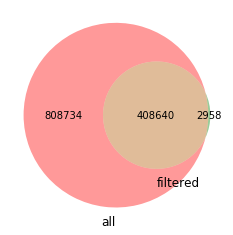

In [9]:
conf = 0
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])

In [10]:
list(set(filtered_df['pos']).difference(set(all_df['pos'])))[:10]

['chr7:140702621-140702622:-',
 'chr1:9990504-9990505:-',
 'chr16:29454903-29454904:-',
 'chr5:40831807-40831808:-',
 'chr11:494675-494676:-',
 'chrX:107327757-107327758:-',
 'chr15:69745224-69745225:+',
 'chr8:48872540-48872541:-',
 'chr9:19056723-19056724:-',
 'chr2:242615368-242615369:-']

Looking at a few examples it appears that these sites are of false sites or sites with multiple alleles found at an extremely low edit fraction. And so what is happening is that the RPS2 (all) has such high coverage that bcftools call is actually calling a different variant.

```bash
RPS2 (filtered)

22      39773703        .       C       T       212.547 .       DP=3702;DPR=3673,1;VDB=0.26;SGB=-0.453602;RPB=0.941056;MQB=1;BQB=0.90716;MQ0F=0;AF1=0;AC1=0;DP4=3673,0,2,0;MQ=20;FQ=-289.528;PV4=1,1,1,1        GT:PL:DP:DV:SP:DP4:DPR     0/0:0,255,172:3675:2:0:3673,0,2,0:3673,1

RPS2 (all)

22      39773703        .       C       G       211.547 .       DP=13512;DPR=13398,7;VDB=0.0292593;SGB=-0.680642;RPB=0.65738;MQB=1;BQB=0.853391;MQ0F=0;AF1=0;AC1=0;DP4=13398,0,12,0;MQ=20;FQ=-289.528;PV4=1,1,1,1 GT:PL:DP:DV:SP:DP4:DPR   0/0:0,255,171:13410:12:0:13398,0,12,0:13398,7
```

In [11]:
filtered_df

,chrom,start,end,name,score,strand,pos
0,chr1,29990,29991,0.999980,"3,7",+,chr1:29990-29991:+
1,chr1,30662,30663,0.950990,"1,6",+,chr1:30662-30663:+
2,chr1,719860,719861,0.960596,"1,5",+,chr1:719860-719861:+
3,chr1,720211,720212,0.868746,"1,15",+,chr1:720211-720212:+
4,chr1,722356,722357,0.777821,"1,26",+,chr1:722356-722357:+
5,chr1,722410,722411,0.950990,"1,6",+,chr1:722410-722411:+
6,chr1,850023,850024,0.443048,"1,82",+,chr1:850023-850024:+
7,chr1,850050,850051,0.412950,"1,89",+,chr1:850050-850051:+
8,chr1,879170,879171,0.465881,"1,77",+,chr1:879170-879171:+
9,chr1,879321,879322,0.077086,"1,256",+,chr1:879321-879322:+


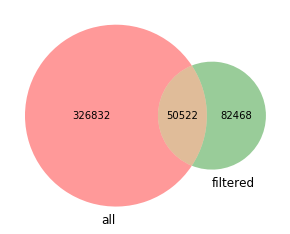

In [9]:
conf = 0.5
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])

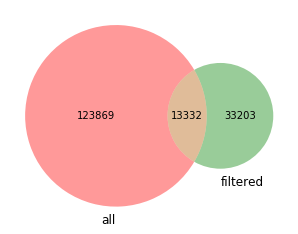

In [10]:
conf = 0.9
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])

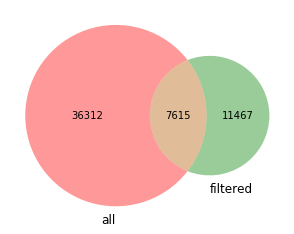

In [11]:
conf = 0.99
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])

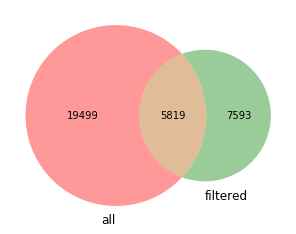

In [12]:
conf = 0.999
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])

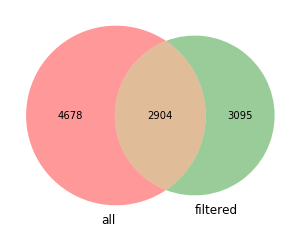

In [13]:
conf = 1
all_df = filter_conf(all_df, conf)
filtered_df = filter_conf(filtered_df, conf)
venn2([set(all_df['pos']), set(filtered_df['pos'])], ['all', 'filtered'])